In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('E:/files/Kaggle/Home Credit Default Risk/application_train.csv')
test = pd.read_csv('E:/files/Kaggle/Home Credit Default Risk/application_test.csv')
# previous_application = pd.read_csv('E:/files/Kaggle/Home Credit Default Risk/previous_application.csv')
y_train = train['TARGET']

In [12]:
for i in test.columns:
    if test[i].dtypes=='object':
        test[i]=test[i].astype('category')

In [ ]:
test.

In [6]:
train['EXT_SOURCE_3'].describe()

count    246546.000000
mean          0.510853
std           0.194844
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64

In [12]:
train.shape

(307511, 122)

In [13]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [14]:
train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [15]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [16]:
train.dtypes.value_counts()# 各类型特征数量

float64    65
int64      41
object     16
dtype: int64

In [17]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)# 字符特征的特征值数量

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [33]:
train.groupby('CODE_GENDER').size()

CODE_GENDER
F    202448
M    105059
dtype: int64

In [3]:
def application_train(train, test):
    # 所有贷款申请的静态数据，一行代表我们数据样本中的一笔贷款
    train['CODE_GENDER'].replace('XNA', np.nan, inplace=True)  # 性别CODE_GENDER
    train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)  # 工作天数
    train['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)  # 家庭（婚姻）状况
    train['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)  # 工作类型

    test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    test['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
    test['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)

    train['annuity_income_percentage'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']  # 贷款年金/年收入
    train['car_to_birth_ratio'] = train['OWN_CAR_AGE'] / train['DAYS_BIRTH']  # 车龄/年龄
    train['car_to_employ_ratio'] = train['OWN_CAR_AGE'] / train['DAYS_EMPLOYED']  # 车龄/工作天数
    train['children_ratio'] = train['CNT_CHILDREN'] / train['CNT_FAM_MEMBERS']  # 孩子数量/家庭成员数量
    train['credit_to_annuity_ratio'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']  # 贷款金额/贷款年金
    train['credit_to_goods_ratio'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']  # 贷款金额/消费贷款额度
    train['credit_to_income_ratio'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']  # 贷款金额/年收入
    train['days_employed_percentage'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']  # 工作天数/年龄
    # External sources
    train['external_sources_weighted'] = train.EXT_SOURCE_1 * 2 + train.EXT_SOURCE_2 * 3 + train.EXT_SOURCE_3 * 4
    for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
        train['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
            train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
    train['income_credit_percentage'] = train['AMT_INCOME_TOTAL'] / train['AMT_CREDIT']  # 年收入/贷款金额
    train['income_per_child'] = train['AMT_INCOME_TOTAL'] / (1 + train['CNT_CHILDREN'])  # 年收入/孩子数
    train['income_per_person'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']  # 年收入/家庭成员数量
    train['payment_rate'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']  # 贷款年金/贷款金额
    train['phone_to_birth_ratio'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_BIRTH']  # 改变电话天数/年龄
    train['phone_to_employ_ratio'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_EMPLOYED']  # 改变电话天数/工作天数

    test['annuity_income_percentage'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    test['car_to_birth_ratio'] = test['OWN_CAR_AGE'] / test['DAYS_BIRTH']
    test['car_to_employ_ratio'] = test['OWN_CAR_AGE'] / test['DAYS_EMPLOYED']
    test['children_ratio'] = test['CNT_CHILDREN'] / test['CNT_FAM_MEMBERS']
    test['credit_to_annuity_ratio'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']
    test['credit_to_goods_ratio'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']
    test['credit_to_income_ratio'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
    test['days_employed_percentage'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
    # External sources
    test['external_sources_weighted'] = test.EXT_SOURCE_1 * 2 + test.EXT_SOURCE_2 * 3 + test.EXT_SOURCE_3 * 4
    for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
        test['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
            test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
    test['income_credit_percentage'] = test['AMT_INCOME_TOTAL'] / test['AMT_CREDIT']
    test['income_per_child'] = test['AMT_INCOME_TOTAL'] / (1 + test['CNT_CHILDREN'])
    test['income_per_person'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
    test['payment_rate'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
    test['phone_to_birth_ratio'] = test['DAYS_LAST_PHONE_CHANGE'] / test['DAYS_BIRTH']
    test['phone_to_employ_ratio'] = test['DAYS_LAST_PHONE_CHANGE'] / test['DAYS_EMPLOYED']
    
    AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
    ]

    for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
        group_object = train.groupby(groupby_cols)
        for select, agg in tqdm(specs):
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            train = train.merge(group_object[select]
                                  .agg(agg)
                                  .reset_index()
                                  .rename(index=str,
                                          columns={select: groupby_aggregate_name})
                                  [groupby_cols + [groupby_aggregate_name]],
                                  on=groupby_cols,
                                  how='left')
    for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
        group_object = test.groupby(groupby_cols)
        for select, agg in tqdm(specs):
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            test = test.merge(group_object[select]
                                  .agg(agg)
                                  .reset_index()
                                  .rename(index=str,
                                          columns={select: groupby_aggregate_name})
                                  [groupby_cols + [groupby_aggregate_name]],
                                  on=groupby_cols,
                                  how='left')

    return train, test

train, test = application_train(train, test)

In [6]:
# one-hot encoding of categorical variables
X_train = pd.get_dummies(train)
X_test = pd.get_dummies(test)
X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)

In [5]:
train['OCCUPATION_TYPE_mean_EXT_SOURCE_3'].head()

0    0.502093
1    0.494627
2    0.502093
3    0.502093
4    0.494627
Name: OCCUPATION_TYPE_mean_EXT_SOURCE_3, dtype: float64

In [37]:
X_eng = X_train.join(y_train, how='left')
X_eng = X_eng.drop(['SK_ID_CURR'], axis=1)
X_eng_corr = abs(X_eng.corrwith(X_eng['TARGET']))
# X_eng_corr.sort_values('TARGET', ascending=False)
# X_eng_corr[X_eng_corr>0.1].index
X_eng_corr.sort_values(ascending=False)

OCCUPATION_TYPE_Private service staff                                                       0.005047
NAME_HOUSING_TYPE_Office apartment                                                          0.005103
WEEKDAY_APPR_PROCESS_START_MONDAY                                                           0.005149
NAME_EDUCATION_TYPE_Academic degree                                                         0.005294
HOUSETYPE_MODE_specific housing                                                             0.005311
ORGANIZATION_TYPE_Industry: type 9                                                          0.005379
FLAG_DOCUMENT_2                                                                             0.005417
ORGANIZATION_TYPE_Industry: type 12                                                         0.005444
REG_REGION_NOT_LIVE_REGION                                                                  0.005576
ORGANIZATION_TYPE_Kindergarten                                                             

In [41]:
selected_features=X_eng_corr[X_eng_corr>0.005]
selected_features=selected_features.index.values.tolist()
selected_features.remove('TARGET')
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_train.shape

(307511, 210)

In [42]:
X_train

,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No
0,0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,...,1,0,1,0,0,0,0,1,0,1
1,0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,...,1,0,1,0,1,0,0,0,0,1
2,0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,...,0,0,0,0,0,0,0,0,0,0
3,0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,...,0,0,0,0,0,0,0,0,0,0
4,0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,...,0,0,0,0,0,0,0,0,0,0
5,0,490495.5,27517.5,454500.0,0.035792,-16941,-1588.0,-4970.0,-477,NaN,...,0,0,0,0,0,0,0,0,0,0
6,1,1560726.0,41301.0,1395000.0,0.035792,-13778,-3130.0,-1213.0,-619,17.0,...,0,0,0,0,0,0,0,0,0,0
7,0,1530000.0,42075.0,1530000.0,0.003122,-18850,-449.0,-4597.0,-2379,8.0,...,0,0,0,0,0,0,0,0,0,0
8,0,1019610.0,33826.5,913500.0,0.018634,-20099,NaN,-7427.0,-3514,NaN,...,0,0,0,0,0,0,0,0,0,0
9,0,405000.0,20250.0,405000.0,0.019689,-14469,-2019.0,-14437.0,-3992,NaN,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train.columns.values

array(['SK_ID_CURR', 'FLAG_CONT_MOBILE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_18', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL',
       'FLAG_PHONE', 'FLAG_WORK_PHONE', 'HOUR_APPR_PROCESS_START',
       'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'annuity_income_percentage', 'car_to_birth_ratio',
       'car_to_employ_ratio', 'children_ratio', 'credit_to_annuity_ratio',
       'credit_to_goods_ratio', 'credit_to_income_ratio',
       'days_employed_percentage', 'ext_sources_mean',
       'income_credit_percentage', 'income_per_child',
       'income_per_person', 'payment_rate', 'phone_to_birth_ratio',
       'phone_to_employ_ratio', 'CODE

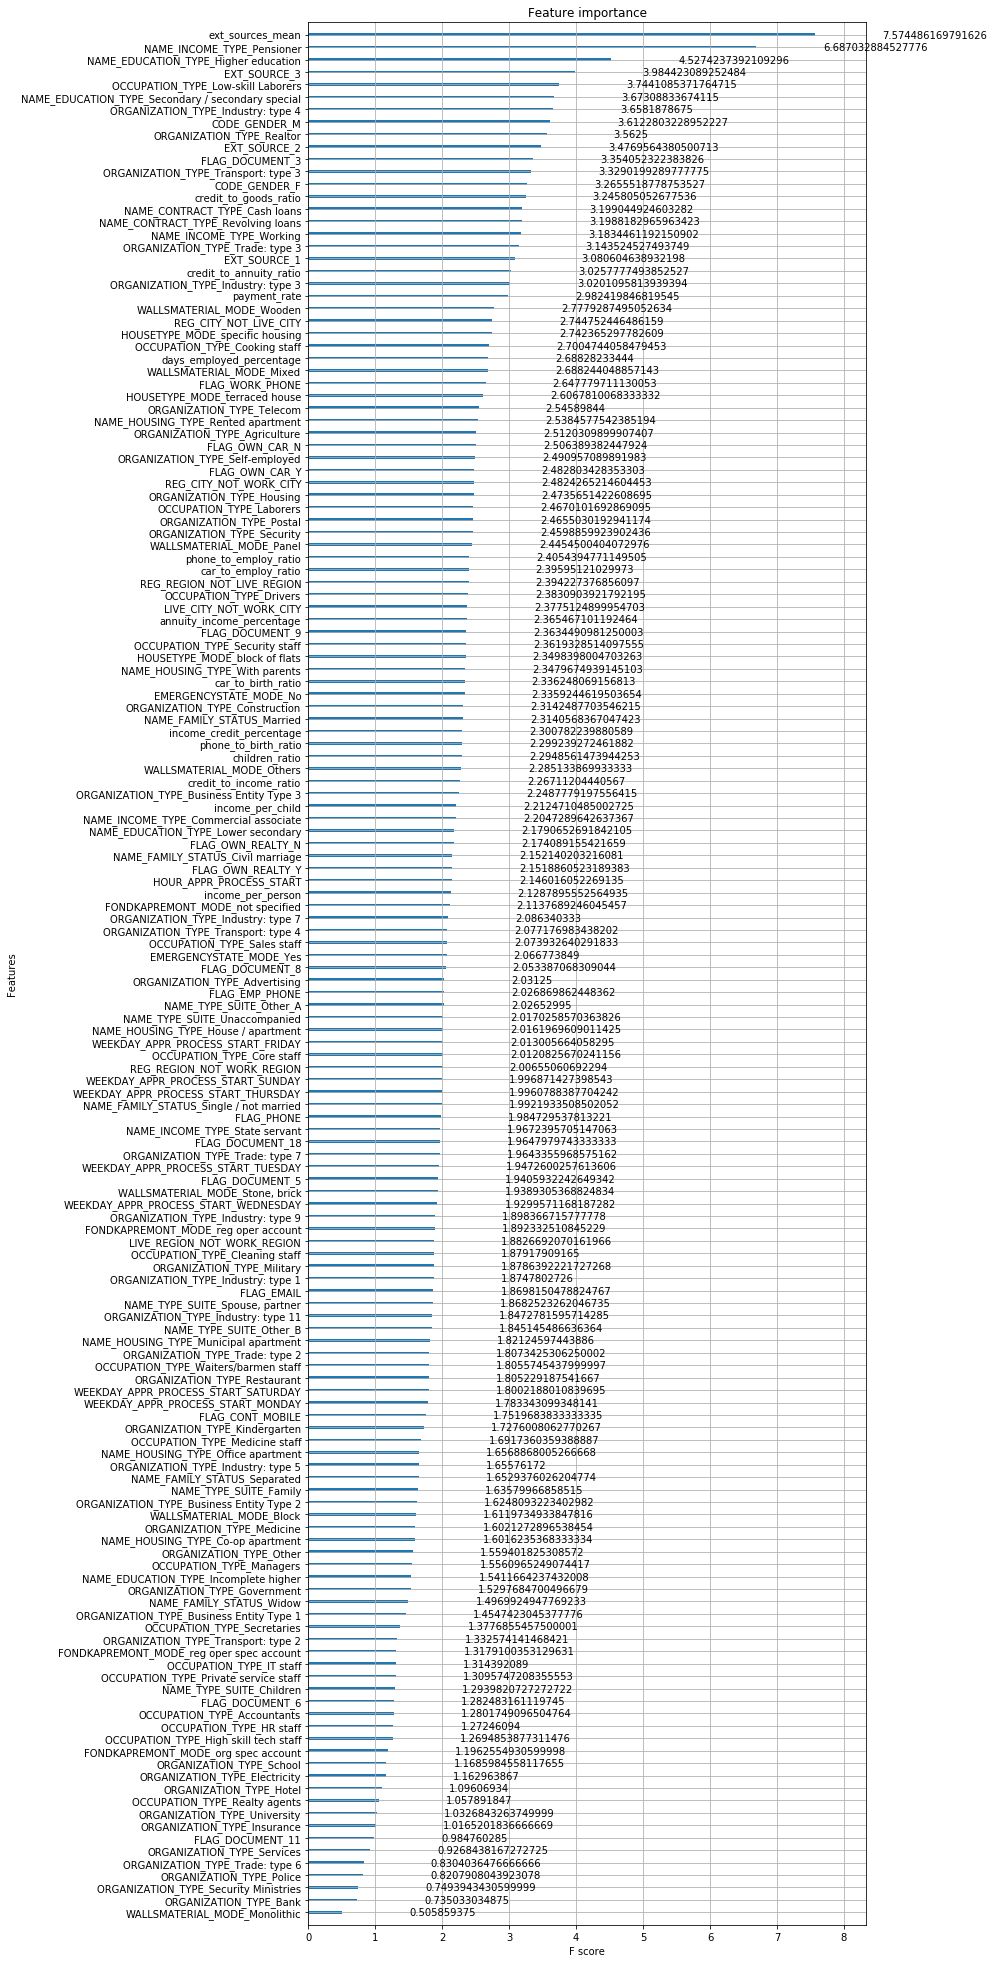

In [26]:
fig, ax = plt.subplots(figsize=(10,35))
xgb.plot_importance(xgb_model, importance_type='gain',ax=ax)